# Multi-class Classification - Reuters Dataset

Dataset by Reuters in 1986 as a set of short newswires and their topics. (https://keras.io/api/datasets/reuters/)
Previously we looked at predicting a binary-classification problem; however, the same techniques can be used to predict many different classes. In the case of the Reuters dataset, we have 46 topics which can be predicted.

Much of what we're covering here are detailed in Chollet (2021) Section 3.4 Getting Started with Neural Networks: Classification and Regression - 4.2 Classifying newswires: A multiclass classification example, if you wish to also read along.

## Requirements
As previously, if we encounter a `ModuleNotFound` error, we should install the appropriate packages. You should already have all relevant packages from last week; however, you can uncomment the magic-commands below if you need to reinstall these.

In [1]:
#%pip install keras
#%pip install tensorflow
#%pip install numpy
#%pip install scikit-learn
#%pip install pandas

We can get rid of those pesky info / warning messages which tensorflow outputs and clogs up our output with the following. Make sure to do this prior to importing tensorflow.

In detail:

* 0 = all messages are logged (default behavior)
* 1 = INFO messages are not printed
* 2 = INFO and WARNING messages are not printed
* 3 = INFO, WARNING, and ERROR messages are not printed

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Introduction


In [3]:
from keras.datasets import reuters

# Utility function provided by Keras.
# num_words limits the results to the most frequent 10K words in the dataset; these will be our number of features.
# test_split - The function already performs shuffled train-test split for us, we can define how big the test-split should be.
# seed - Random seed for shuffling. Delete if you want randomness everytime.

#reuters.load_data(num_words = 10000)
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = 10000, test_split = 0.3, seed=42)

In [4]:
print(f"X Train length: {len(X_train)}")
print(f"y Train length: {len(y_train)}")
print(f"X Test length: {len(X_test)}")
print(f"y Test length: {len(y_test)}")

print(f"Total data examples: {len(X_train) + len(X_test)}")

X Train length: 7859
y Train length: 7859
X Test length: 3369
y Test length: 3369
Total data examples: 11228


Let's investigate what the data looks like.

In [5]:
print(X_train[0])

# And the label
print(y_train[0]) # -> 3

[1, 39, 566, 11, 14, 841, 11, 29, 53, 617, 187, 193, 15, 14, 134, 533, 15, 53, 175, 3758, 948, 15, 14, 4313, 279, 15, 39, 4074, 11, 14, 3814, 11, 123, 248, 867, 377, 1471, 81, 2, 64, 187, 6164, 2116, 617, 79, 335, 7, 48, 14, 187, 6164, 4656, 7, 105, 324, 27, 69, 12, 18, 730, 1698, 5, 4, 134, 248, 867, 377, 171, 2, 75, 40, 251, 18, 79, 5, 175, 324, 27, 4, 867, 377, 171, 17, 12]
3


Our input data is simply a sequence of word indices. E.g `[1, 39, 556, 11]` is a sequence of word 1, 39, 556, and 11. This seems cryptic, but each index here links to a vocabulary entry. That is, a mapping from id -> word.

In [6]:
vocabulary = reuters.get_word_index()
vocabulary = {v:k for k,v in vocabulary.items()} # Invert the mapping. Numeric indices as keys, words as values. Enables lookup.

for k,v in vocabulary.items():
    print(k, v)

10996 mdbl
16260 fawc
12089 degussa
8803 woods
13796 hanging
20672 localized
20673 sation
20675 chanthaburi
10997 refunding
8804 hermann
20676 passsengers
20677 stipulate
8352 heublein
20713 screaming
16261 tcby
185 four
1642 grains
20680 broiler
12090 wooden
1220 wednesday
13797 highveld
7593 duffour
20681 0053
3914 elections
2563 270
3551 271
5113 272
3552 273
3400 274
7975 rudman
3401 276
3478 277
3632 278
4309 279
9381 dormancy
7247 errors
3086 deferred
20683 sptnd
8805 cooking
20684 stratabit
16262 designing
20685 metalurgicos
13798 databank
20686 300er
20687 shocks
7972 nawg
20688 tnta
20689 perforations
2891 affiliates
20690 27p
16263 ching
595 china
16264 wagyu
3189 affiliated
16265 chino
16266 chinh
20692 slickline
13799 doldrums
12092 kids
3028 climbed
6693 controversy
20693 kidd
12093 spotty
12639 rebel
9382 millimetres
4007 golden
5689 projection
12094 stern
7903 hudson's
10066 dna
20695 dnc
20696 hodler
2394 lme
20697 insolvancy
13800 music
1984 therefore
10998 dns
6959 di

For our first news article (index 0), let's go through each of those word indices and look up what the corresponding word from the article is. This should give us a better idea that the articles are just encoded as numbers linking to a fixed vocabulary. With the problem being numeric, we can now begin to solve *this* problem. 

Note: If we were to change the vocabulary mapping, then any trained models would no longer work and we'd need to re-train on the new mapping.

In [7]:
for word_idx in X_train[0]:
    print( vocabulary.get(word_idx - 3, '?') )
     # Indices 0, 1, and 2 are reserved. Therefore we offset by 3. If a word cannot be found, use a '?'.

?
net
65
mln
vs
57
mln
year
shr
preferred
14
87
dlrs
vs
12
51
dlrs
shr
common
236
77
dlrs
vs
197
40
dlrs
net
247
mln
vs
208
mln
note
federal
home
loan
mortgage
corp
?
had
14
998
210
preferred
shares
outstanding
in
1986
vs
14
998
379
in
1985
owned
by
about
3
000
member
institutions
of
the
12
federal
home
loan
banks
?
also
has
100
000
shares
of
common
owned
by
the
home
loan
banks
reuter
3


## Pre-processing
At the moment our labels are integers. For Categorical Cross-entropy, we will require a column per outcome. E.g If we have 3 classes, then our y label should have 3 features. We call this `one-hot encoding`. Where the appropriate class is set to 1 (hot).

E.g For Class 3 we would have the vector `[0, 0, 1]`; Class 2 `[0, 1, 0]`; and Class 1 `[1, 0, 0]`. Vectors such as `[0, 0, 0]` and `[1, 1, 0]` or `[1, 1, 1]` would be erroneous.

E.g For a 5 class problem we would have a vector `[0, 0, 0, 0, 0]`, then just set the class = 1. E.g Class 3 would be `[0, 0, 1, 0, 0]`.

We will use this same concept to convert our input data - a 10,000 word vocabulary mapping - as well as our target/labels ready for our neural network to understand.

In [ ]:
import numpy as np

# First create an empty numpy matrix full of 0.
# Shape will be the number of rows of data we have, and at each row we will have a 10,000 column vector.
x_train_enc = np.zeros(shape=(len(X_train),10000) )
print(x_train_enc.shape)

# E.g 7859, 10000
# Each row has a 10K dimension vector stored. Each index of that 10K vector represent a word index.

for row_number, word_idx_seq in enumerate(X_train):
    # Wherever we have a word_index, set the appropriate index in the 10K vector to 1
    # E.g [ 1, 39, 566 ] would set index 1, 39, and 566 of our 10K vector to 1. All else would be 0.
    x_train_enc[ row_number, word_idx_seq] = 1

print(x_train_enc[0])


### Same for the x_test set now. Yes, we could make a function for this.


x_test_enc = np.zeros( shape=(len(X_test),10000) )
for row_number, word_idx_seq in enumerate(X_test):
    x_test_enc[ row_number, word_idx_seq] = 1

print(x_test_enc[0])



(7859, 10000)
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]


We can use a numpy utility to help us convert the labels. Going from integers -> vectors for each row.

In [9]:
from tensorflow.keras.utils import to_categorical
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

In [10]:
print(y_train_enc.shape) # 46 dimensional vector now.

(7859, 46)


In [26]:
y_train_enc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(7859, 46))

## Model Definition
Now we have our input data in a format which works for us (one-hot encoding), let's define a model. Previously we defined quite a small Neural Network as our 'problem' was much simpler (wine). Today we're going to explore how changing these impacts our loss metrics, and how we can make some decisions on our architecture based on those.

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Model from last week:

```python
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=(11,))) # 11 Columns of input
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid")) # 0->1 floating
model.summary()
```

A few changes we will make:
* Input shape changing from 11-dimension to 1000-dimension
* Additional hidden layer
* Output number of neurons will be 46 - to represent the number of news topics.
* Change of activation in final layer to `softmax`. Softmax outputs a probability distribution. We want a N-dimensional vector output where we can just take the argmax to find the predicted class.

In [ ]:
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=(10000,))) # 10000 dimensional input.
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(64, activation="relu")) # 2 Hidden Layers
model.add(layers.Dense(46, activation="softmax")) # 46 Output topics possible.
model.summary()




c:\Users\kojus\anaconda3\envs\ML_DM\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Previously we specified `optimizer='sgd'`, if we want more control we should create our optimisers explicitly and define their values. This will become important in later weeks. For now we will define a standard SGD optimiser, with default learning rate.

```python
from keras.optimizers import SGD

model.compile(...
    optimizer=SGD(learning_rate=0.01)
...)
```

Additionally, as we are **NOT** doing a binary classification problem we must change our loss function to account for the categoric approach we've taken. Instead of **binary**_crossentropy we will be using **categorical**_crossentropy

```python
model.compile(
    loss='categorical_crossentropy',
    ...
)
```

In [13]:
from tensorflow.keras.optimizers import SGD

# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.05), # Higher learning rate
    metrics=['accuracy']
)

### Training

Here we fit our model using the standard procedure from last week. We stored the training history in an object for plotting later, providing metrics per epoch. We provide training x and y data, as well as a number of epochs.

A new change for this week, is the introduction of the `batch_size` keyword. This allows us to control the mini-batch which is used in the optimiser (SGD). Recall from last week's reading the range from entire-data to single example for calculation of gradients. Mini-batches are the middle ground. By default Keras uses batch sizes of 32. It should be noted that this parameter has diminishing returns. Using a batch size of 64 is not twice as good as 32. For more complex data, we run into memory limitations where we cannot physically store that many data examples in one-go.

Additionally, we're going to provide a `validation set` for it to calculate validation loss automaticaly on. We're going to grab 1000 examples from our training set to hold back for this purpose. This is important for us to make quick decisions from the training and validation set differences as to how to tweak our model.

In [14]:
# Slice notation
x_val = x_train_enc[:1000] # Grab from 0 -> 1000
y_val = y_train_enc[:1000]

x_train_enc_rest = x_train_enc[1000:] # From 1000 -> end
y_train_enc_rest = y_train_enc[1000:]

model_training_history = model.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 120,
    validation_data = (x_val, y_val)
)

Epoch 1/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.3665 - loss: 3.5358 - val_accuracy: 0.4290 - val_loss: 3.0327
Epoch 2/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4428 - loss: 2.6275 - val_accuracy: 0.4960 - val_loss: 2.2613
Epoch 3/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5055 - loss: 2.1671 - val_accuracy: 0.5230 - val_loss: 2.0192
Epoch 4/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5171 - loss: 1.9885 - val_accuracy: 0.5290 - val_loss: 1.8997
Epoch 5/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5243 - loss: 1.8810 - val_accuracy: 0.5350 - val_loss: 1.8180
Epoch 6/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5406 - loss: 1.8004 - val_accuracy: 0.5490 - val_loss: 1.7554
Epoch 7/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5571 - loss: 1.7367 - val_accuracy: 0.5630 - val_loss: 1.7083
Epoch 8/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 1.6844 - val_accuracy: 0

### Evaluating

Let's use the plotting functionality covered last week. We will modify it to overlay the validation set loss over the training set on a single figure. Here we have gone back in and used `plt.axvline()` function to plot a vertical line.

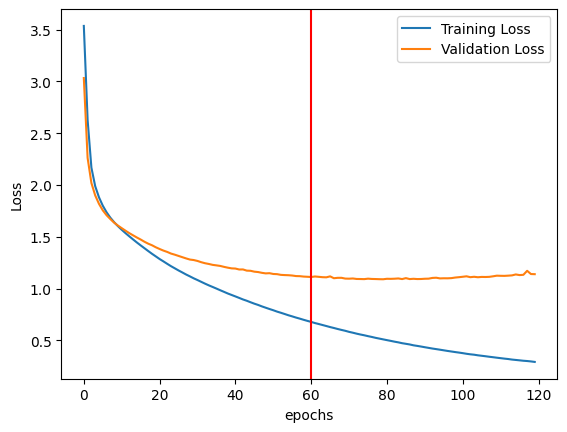

In [15]:
import matplotlib.pyplot as plt

# If we want to be fancy, we can set a theme by uncommenting the below line.
#plt.style.use('ggplot')

# No subplots here, as we're just drawing over the same plot with multiple data.

# Loss and Val Loss metrics.
loss = model_training_history.history['loss']
val_loss = model_training_history.history['val_loss']


# Training loss, and Validation loss. Providing labels is useful for our legend later.
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
    
# X and Y axes labels.
plt.ylabel('Loss')
plt.xlabel('epochs')

# Draw a red vertical line at x=60.
plt.axvline(x=60, color='red')

# Display a legend.
plt.legend()

Based on our results here we begin to overfit around the x=60 - x=100 mark. In the end we have a training accuracy of approx 93% with validation accuracy of 77%.

At this point we should re-train our whole model, stopping at Epoch = 60. Then we can evaluate our model.

___

##### Task: Reinitialise model, retrain cutting training off at the optimal point
**TODO**:
* Add code below to re-create, re-compile, and re-train the NN setting epochs = 40 (or another suitable point where we begin to overfit)
* Add code to generate evaluation metrics for the entire test set. Note, A confusion matrix here would be a 46x46 matrix... Standard accuracy here is fine.

If we predict using the final model after 120 epochs, we've already overfit at this point. We know our model will not generalise well, and we can expect poor test-set performance. The reason for retraining and stopping at the 'sweet spot' is that we end up with a 'good' model which hasn't yet overfit and isn't underfit. It's the best it can currently be (given the architecture so far).

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3353 - loss: 2.9790 - val_accuracy: 0.3650 - val_loss: 2.3860
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5047 - loss: 1.9435 - val_accuracy: 0.5930 - val_loss: 1.7370
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6192 - loss: 1.6045 - val_accuracy: 0.5950 - val_loss: 1.5925
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.6629 - loss: 1.4317 - val_accuracy: 0.6670 - val_loss: 1.4127
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.6995 - loss: 1.2652 - val_accuracy: 0.7040 - val_loss: 1.3098
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6896 - loss: 1.2724 - val_accuracy: 0.6900 - val_loss: 1.2702
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7578 - loss: 1.0388 - val_accuracy: 0.6950 - val_loss: 1.2815
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7590 - loss: 1.0261 - val_accuracy: 0.7260 -

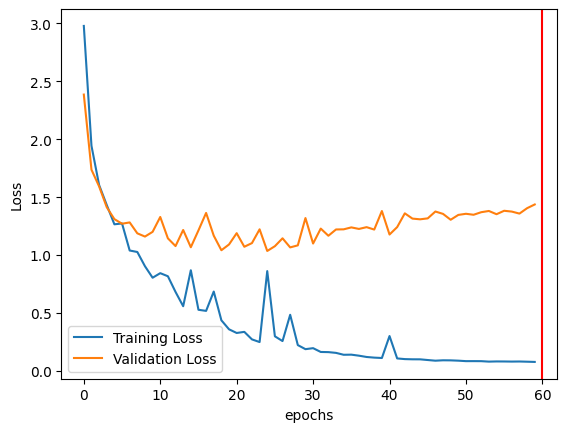

In [51]:
### TODO:
# Re-create, re-compile, re-train the NN model, setting epochs = 40.

#Re-create
model_task = keras.Sequential([
    layers.InputLayer(input_shape=(10000,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(46,activation="softmax")    
])

model_task.summary()

#Re-Compile
model_task.compile(
    optimizer=SGD(learning_rate=0.5),
    loss='categorical_crossentropy',
    metrics=['accuracy']

)


#Re-Train
model_task_training_history = model_task.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 60,
    validation_data = (x_val, y_val)
)


#Prediction

pred_y = model_task.predict(x_test_enc)

# Let's look at the first prediction output. To get a feeling for the shape, and values.
print(pred_y[0].shape)
print(pred_y[0])
print(np.sum(pred_y[0])) # Softmax output. Should be approx = 1.

print(np.argmax(pred_y[0])) # Which label is the highest probability


# Loss and Val Loss metrics.
loss = model_task_training_history.history['loss']
val_loss = model_task_training_history.history['val_loss']


# Training loss, and Validation loss. Providing labels is useful for our legend later.
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
    
# X and Y axes labels.
plt.ylabel('Loss')
plt.xlabel('epochs')

# Draw a red vertical line at x=60.
plt.axvline(x=60, color='red')

# Display a legend.
plt.legend()

<span style="color: #87CEEB;"> Observation </span>:
- _the steep is very slope and this could be because of the learning rate is high; so will reduce the learning rate._

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0993 - loss: 3.7940 - val_accuracy: 0.2610 - val_loss: 3.7570
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3224 - loss: 3.7222 - val_accuracy: 0.4120 - val_loss: 3.6715
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4227 - loss: 3.6280 - val_accuracy: 0.4670 - val_loss: 3.5617
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4595 - loss: 3.5051 - val_accuracy: 0.4860 - val_loss: 3.4154
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4743 - loss: 3.3399 - val_accuracy: 0.4930 - val_loss: 3.2194
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4779 - loss: 3.1281 - val_accuracy: 0.4990 - val_loss: 2.9858
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4649 - loss: 2.9003 - val_accuracy: 0.4730 - val_loss: 2.7678
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4448 - loss: 2.7127 - val_accuracy: 0.4470 - v

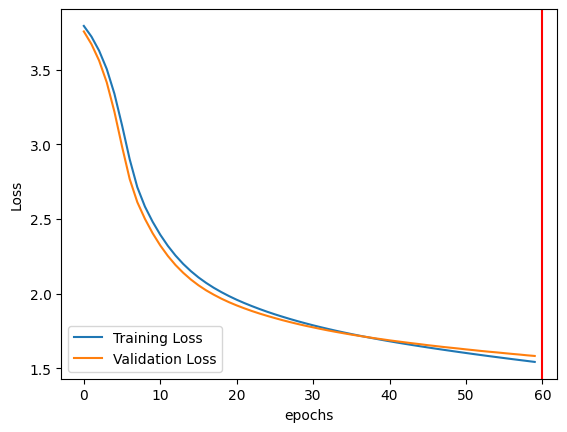

In [59]:
### Lower Learning Rate:
# Re-create, re-compile, re-train the NN model, setting epochs = 40.

#Re-create
model_task_2 = keras.Sequential([
    layers.InputLayer(input_shape=(10000,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(46,activation="softmax")    
])

model_task_2.summary()

#Re-Compile
model_task_2.compile(
    optimizer=SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']

)


#Re-Train
model_task_2_training_history = model_task_2.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 60,
    validation_data = (x_val, y_val)
)


#Prediction

pred_y = model_task_2.predict(x_test_enc)

# Let's look at the first prediction output. To get a feeling for the shape, and values.
print(pred_y[0].shape)
print(pred_y[0])
print(np.sum(pred_y[0])) # Softmax output. Should be approx = 1.

print(np.argmax(pred_y[0])) # Which label is the highest probability


# Loss and Val Loss metrics.
loss = model_task_2_training_history.history['loss']
val_loss = model_task_2_training_history.history['val_loss']


# Training loss, and Validation loss. Providing labels is useful for our legend later.
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
    
# X and Y axes labels.
plt.ylabel('Loss')
plt.xlabel('epochs')

# Draw a red vertical line at x=60.
plt.axvline(x=60, color='red')

# Display a legend.
plt.legend()

it appears to be a good model- but may need to increase the epochs- to enable a divergence and get the robust fit for the model.

c:\Users\kojus\anaconda3\envs\ML_DM\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.0461 - loss: 3.8299 - val_accuracy: 0.1970 - val_loss: 3.8032
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2839 - loss: 3.7806 - val_accuracy: 0.3550 - val_loss: 3.7523
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3517 - loss: 3.7275 - val_accuracy: 0.3640 - val_loss: 3.6923
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3521 - loss: 3.6613 - val_accuracy: 0.3650 - val_loss: 3.6141
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3506 - loss: 3.5746 - val_accuracy: 0.3660 - val_loss: 3.5137
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3501 - loss: 3.4647 - val_accuracy: 0.3650 - val_loss: 3.3878
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3499 - loss: 3.3276 - val_accuracy: 0.3650 - val_loss: 3.2328
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3499 - loss: 3.1609 - val_accuracy: 0.

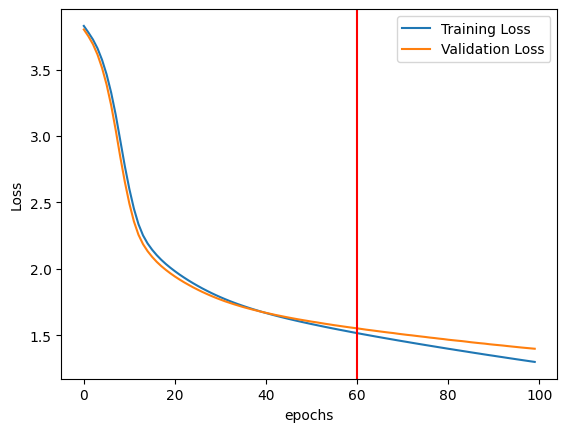

In [60]:
### Lower Learning Rate:
# Re-create, re-compile, re-train the NN model, setting epochs = 40.

#Re-create
model_task_3= keras.Sequential([
    layers.InputLayer(input_shape=(10000,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(46,activation="softmax")    
])

model_task_3.summary()

#Re-Compile
model_task_3.compile(
    optimizer=SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']

)


#Re-Train
model_task_3_training_history = model_task_3.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 100,
    validation_data = (x_val, y_val)
)


#Prediction

pred_y = model_task_3.predict(x_test_enc)

# Let's look at the first prediction output. To get a feeling for the shape, and values.
print(pred_y[0].shape)
print(pred_y[0])
print(np.sum(pred_y[0])) # Softmax output. Should be approx = 1.

print(np.argmax(pred_y[0])) # Which label is the highest probability


# Loss and Val Loss metrics.
loss = model_task_3_training_history.history['loss']
val_loss = model_task_3_training_history.history['val_loss']


# Training loss, and Validation loss. Providing labels is useful for our legend later.
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
    
# X and Y axes labels.
plt.ylabel('Loss')
plt.xlabel('epochs')

# Draw a red vertical line at x=60.
plt.axvline(x=60, color='red')

# Display a legend.
plt.legend()

Got a <span style="color:#87CEEB;"> Robust Fit </span> at:

- learning_rate= 0.01
- and increase epoch to 100
- the sweet spot falls around epoch 40

---

### Information Bottleneck
Let's modify our model definition to decrease the number of neurons in the hidden layer. This will behave as a 'pinch' going from 10000 -> 4 -> 4 -> 46.
Fundamentally, we're going to observe an inability of our neural network to model the problem's complexity well enough.

In theory, forcing a small bottleneck can be advantagegous to push the network to learn dense and compact representations of problems. But too much bottlenecking (and too quickly) can cause loss of information between stages.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 4)              │        40,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │           230 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,254 (157.24 KB)

 Trainable params: 40,254 (157.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3148 - loss: 3.7633 - val_accuracy: 0.3630 - val_loss: 3.6715
Epoch 2/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3502 - loss: 3.5822 - val_accuracy: 0.3640 - val_loss: 3.4339
Epoch 3/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3503 - loss: 3.2489 - val_accuracy: 0.3650 - val_loss: 2.9136
Epoch 4/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3517 - loss: 2.6599 - val_accuracy: 0.3830 - val_loss: 2.3728
Epoch 5/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4148 - loss: 2.2902 - val_accuracy: 0.4800 - val_loss: 2.1506
Epoch 6/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4858 - loss: 2.1230 - val_accuracy: 0.5110 - val_loss: 2.0378
Epoch 7/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5114 - loss: 2.0253 - val_accuracy: 0.5210 - val_loss: 1.9616
Epoch 8/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5170 - loss: 1.9517 - val_accuracy: 0.

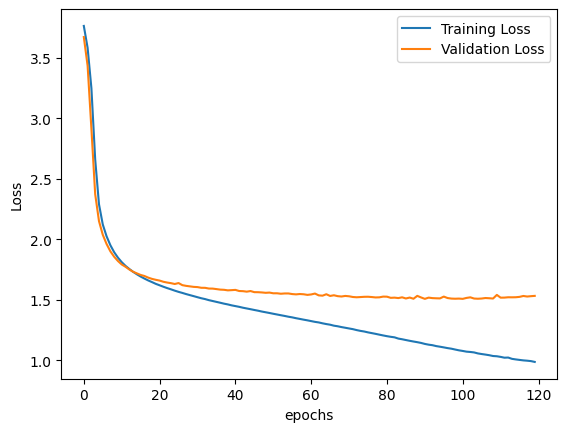

In [ ]:
model2 = keras.Sequential()
model2.add(layers.InputLayer(input_shape=(10000,))) # 10000 dimensional input.
model2.add(layers.Dense(4, activation="relu"))
model2.add(layers.Dense(4, activation="relu")) # 2 Hidden Layers
model2.add(layers.Dense(46, activation="softmax")) # 46 Output topics possible.
model2.summary()

model2.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.05), # Higher learning rate for demonstration.
    metrics=['accuracy']
)

# Using train, test, val datasets from before.
model2_training_history = model2.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 120,
    validation_data = (x_val, y_val)
)

plt.plot(model2_training_history.history['loss'], label="Training Loss")
plt.plot(model2_training_history.history['val_loss'], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()




An overall accuracy of approx 62%. Validation accuracy of approx 60%. The overall loss is far from 0 indicating more training to be done; however, the validation loss has begun to increase indicating overfitting. This is an excellent candidate for adding more neurons / hidden layers. Once we get the training accuracy up, we can also then look at regularisation to address the overfitting.

### Dropout
#### Dropout: alpha = 0.2

In our first example, we might want to try using Dropout to help reduce the gap between validation loss curves and training loss curves. Let's set that up.

We can add Dropout using `layers.Dropout()` layer in our Sequential model, remembering to provide a percentage dropout. Usually 0.2-0.5 are good values.

Here we're going to train for a bit longer, as we would expect Dropout to increase training times slightly.

In [18]:
model3 = keras.Sequential()
model3.add(layers.InputLayer(input_shape=(10000,))) # 10000 dimensional input.

model3.add(layers.Dense(64, activation="relu"))
model3.add(layers.Dropout(0.2))

model3.add(layers.Dense(64, activation="relu")) # 2 Hidden Layers
model3.add(layers.Dropout(0.2))

model3.add(layers.Dense(46, activation="softmax")) # 46 Output topics possible.
model3.summary()

model3.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.05), # Higher learning rate for demonstration.
    metrics=['accuracy']
)

# Using train, test, val datasets from before.
model3_training_history = model3.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 240, # train for a bit longer to get a better picture.
    validation_data = (x_val, y_val)
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3015 - loss: 3.6527 - val_accuracy: 0.4910 - val_loss: 3.3062
Epoch 2/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4483 - loss: 2.9342 - val_accuracy: 0.4710 - val_loss: 2.4577
Epoch 3/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4562 - loss: 2.3788 - val_accuracy: 0.5210 - val_loss: 2.1155
Epoch 4/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4878 - loss: 2.1435 - val_accuracy: 0.5240 - val_loss: 1.9575
Epoch 5/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5069 - loss: 2.0269 - val_accuracy: 0.5290 - val_loss: 1.8677
Epoch 6/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5219 - loss: 1.9352 - val_accuracy: 0.5380 - val_loss: 1.8069
Epoch 7/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5373 - loss: 1.8679 - val_accuracy: 0.5510 - val_loss: 1.7571
Epoch 8/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5494 - loss: 1.8064 - val_accuracy: 0.

#### Dropout: alpha = 0.5
Let's also try a higher value for Dropout, alpha = 0.5

In [19]:
model4 = keras.Sequential()
model4.add(layers.InputLayer(input_shape=(10000,))) # 10000 dimensional input.

model4.add(layers.Dense(64, activation="relu"))
model4.add(layers.Dropout(0.5))

model4.add(layers.Dense(64, activation="relu")) # 2 Hidden Layers
model4.add(layers.Dropout(0.5))

model4.add(layers.Dense(46, activation="softmax")) # 46 Output topics possible.
model4.summary()

model4.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.05), # Higher learning rate for demonstration.
    metrics=['accuracy']
)

# Using train, test, val datasets from before.
model4_training_history = model4.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 240, # train for a bit longer to get a better picture.
    validation_data = (x_val, y_val)
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.1871 - loss: 3.6754 - val_accuracy: 0.3690 - val_loss: 3.3365
Epoch 2/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3588 - loss: 3.0908 - val_accuracy: 0.3720 - val_loss: 2.5798
Epoch 3/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3982 - loss: 2.6185 - val_accuracy: 0.4750 - val_loss: 2.2363
Epoch 4/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4229 - loss: 2.3761 - val_accuracy: 0.5310 - val_loss: 2.0605
Epoch 5/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4527 - loss: 2.2527 - val_accuracy: 0.5290 - val_loss: 1.9581
Epoch 6/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4654 - loss: 2.1565 - val_accuracy: 0.5290 - val_loss: 1.8912
Epoch 7/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4848 - loss: 2.0730 - val_accuracy: 0.5330 - val_loss: 1.8383
Epoch 8/240
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4913 - loss: 2.0179 - val_accuracy: 0.

#### Evaluative graphs
##### Loss
We're going to overlay our original networks Training loss, and Validation Loss on this graph to see how we compare in an absolute way. Remember, the closer the loss is to 0, theoretically the better our network.

To differentiate between Training loss and Validation Loss, we've used dashed lines for training, and solid for validation. Specifically here you should focus on how low the overall loss goes, the divergence between architectures of their training and validation loss curves, and the moment of inflection of the validation loss curves.

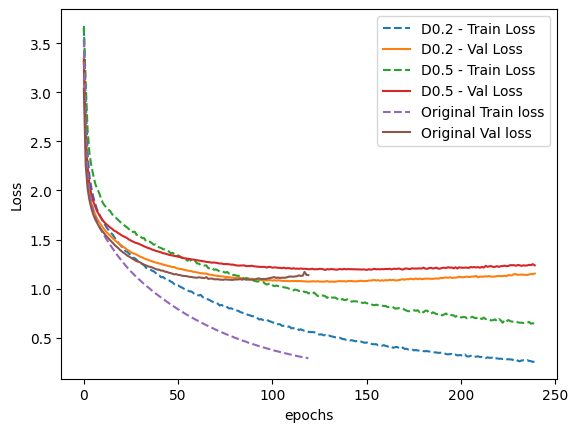

In [20]:
plt.plot(model3_training_history.history['loss'], '--', label="D0.2 - Train Loss")
plt.plot(model3_training_history.history['val_loss'], label="D0.2 - Val Loss")

plt.plot(model4_training_history.history['loss'], '--', label="D0.5 - Train Loss")
plt.plot(model4_training_history.history['val_loss'], label="D0.5 - Val Loss")

plt.plot(model_training_history.history['loss'], '--', label="Original Train loss")
plt.plot(model_training_history.history['val_loss'], label="Original Val loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

##### Accuracy

Looking at the accuracy graphs we can see that the original training accuracy curve improves faster than the others. Intuitively this makes sense, as we have introduced a form of reguluarisation, we may take longer to get to the 'end' of our training.

With Dropout, looking at our accuracy can also be misleading. During training time, we are dropping 20-50% of the neuron connections; however, at test time we are keeping them all.

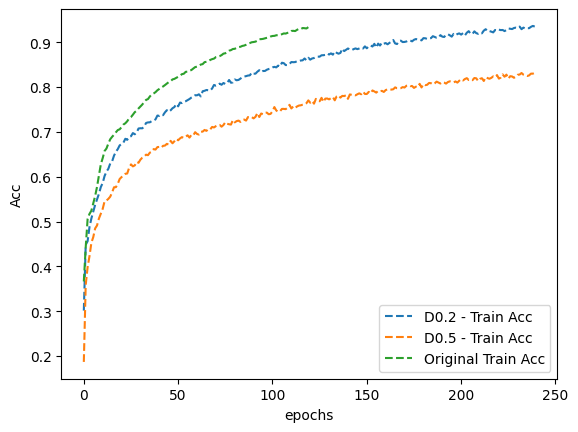

In [21]:
plt.plot(model3_training_history.history['accuracy'], '--', label="D0.2 - Train Acc")
plt.plot(model4_training_history.history['accuracy'], '--', label="D0.5 - Train Acc")
plt.plot(model_training_history.history['accuracy'], '--', label="Original Train Acc")

plt.ylabel('Acc')
plt.xlabel('epochs')
plt.legend()

#### Task: Plot Testing Accuracy

Using the three previously trained models, plot the testing accuracy on a chart. Does this fall in line with our expectations? How has the regularisation helped?

In [30]:
model_training_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

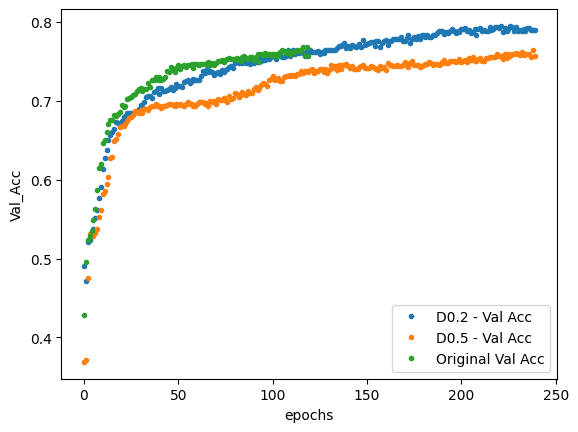

In [33]:
plt.plot(model3_training_history.history['val_accuracy'], '.', label="D0.2 - Val Acc")
plt.plot(model4_training_history.history['val_accuracy'], '.', label="D0.5 - Val Acc")
plt.plot(model_training_history.history['val_accuracy'], '.', label="Original Val Acc")

plt.ylabel('Val_Acc')
plt.xlabel('epochs')
plt.legend()

Further Model Hyper-parameter Tuning

In [34]:
model4 = keras.Sequential()
model4.add(layers.InputLayer(input_shape=(10000,))) # 10000 dimensional input.

model4.add(layers.Dense(64, activation="relu"))
model4.add(layers.Dropout(0.5))

model4.add(layers.Dense(64, activation="relu")) # 2 Hidden Layers
model4.add(layers.Dropout(0.5))

model4.add(layers.Dense(46, activation="softmax")) # 46 Output topics possible.
model4.summary()

model4.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.05), # Higher learning rate for demonstration.
    metrics=['accuracy']
)

# Using train, test, val datasets from before.
model4_training_history = model4.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 500, # train for a bit longer to get a better picture.
    validation_data = (x_val, y_val)
)

c:\Users\kojus\anaconda3\envs\ML_DM\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.2126 - loss: 3.6551 - val_accuracy: 0.3840 - val_loss: 3.3052
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3810 - loss: 3.0567 - val_accuracy: 0.3950 - val_loss: 2.5294
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4116 - loss: 2.5977 - val_accuracy: 0.4820 - val_loss: 2.1938
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4334 - loss: 2.3623 - val_accuracy: 0.5220 - val_loss: 2.0470
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4595 - loss: 2.2535 - val_accuracy: 0.5210 - val_loss: 1.9613
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4749 - loss: 2.1443 - val_accuracy: 0.5270 - val_loss: 1.9083
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4855 - loss: 2.0915 - val_accuracy: 0.5320 - val_loss: 1.8600
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4919 - loss: 2.0314 - val_accuracy: 

In [35]:

model3 = keras.Sequential()
model3.add(layers.InputLayer(input_shape=(10000,))) # 10000 dimensional input.

model3.add(layers.Dense(64, activation="relu"))
model3.add(layers.Dropout(0.2))

model3.add(layers.Dense(64, activation="relu")) # 2 Hidden Layers
model3.add(layers.Dropout(0.2))

model3.add(layers.Dense(46, activation="softmax")) # 46 Output topics possible.
model3.summary()

model3.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.05), # Higher learning rate for demonstration.
    metrics=['accuracy']
)

# Using train, test, val datasets from before.
model3_training_history = model3.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 500, # train for a bit longer to get a better picture.
    validation_data = (x_val, y_val)
)

c:\Users\kojus\anaconda3\envs\ML_DM\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.2430 - loss: 3.6872 - val_accuracy: 0.4790 - val_loss: 3.3839
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4461 - loss: 3.0794 - val_accuracy: 0.5020 - val_loss: 2.5681
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4525 - loss: 2.4666 - val_accuracy: 0.5160 - val_loss: 2.1353
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4712 - loss: 2.1761 - val_accuracy: 0.5200 - val_loss: 1.9445
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4963 - loss: 2.0196 - val_accuracy: 0.5360 - val_loss: 1.8432
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5128 - loss: 1.9245 - val_accuracy: 0.5430 - val_loss: 1.7758
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5326 - loss: 1.8494 - val_accuracy: 0.5680 - val_loss: 1.7261
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5469 - loss: 1.7989 - val_accuracy: 0.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 4)              │        40,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 46)             │           230 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,254 (157.24 KB)

 Trainable params: 40,254 (157.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3041 - loss: 3.7579 - val_accuracy: 0.3650 - val_loss: 3.6424
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3499 - loss: 3.5028 - val_accuracy: 0.3650 - val_loss: 3.2355
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3499 - loss: 2.9465 - val_accuracy: 0.3650 - val_loss: 2.6088
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3499 - loss: 2.4880 - val_accuracy: 0.3650 - val_loss: 2.3270
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3519 - loss: 2.2887 - val_accuracy: 0.3730 - val_loss: 2.1903
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3697 - loss: 2.1680 - val_accuracy: 0.4090 - val_loss: 2.0898
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4154 - loss: 2.0700 - val_accuracy: 0.4630 - val_loss: 2.0073
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4722 - loss: 1.9892 - val_accuracy: 0.

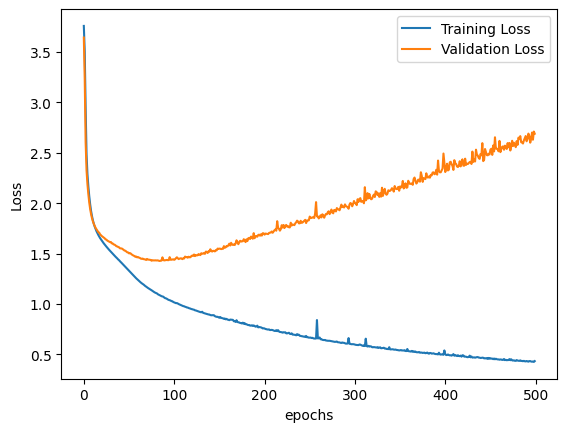

In [36]:
model2 = keras.Sequential()
model2.add(layers.InputLayer(input_shape=(10000,))) # 10000 dimensional input.
model2.add(layers.Dense(4, activation="relu"))
model2.add(layers.Dense(4, activation="relu")) # 2 Hidden Layers
model2.add(layers.Dense(46, activation="softmax")) # 46 Output topics possible.
model2.summary()

model2.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.05), # Higher learning rate for demonstration.
    metrics=['accuracy']
)

# Using train, test, val datasets from before.
model2_training_history = model2.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 500,
    validation_data = (x_val, y_val)
)

plt.plot(model2_training_history.history['loss'], label="Training Loss")
plt.plot(model2_training_history.history['val_loss'], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()


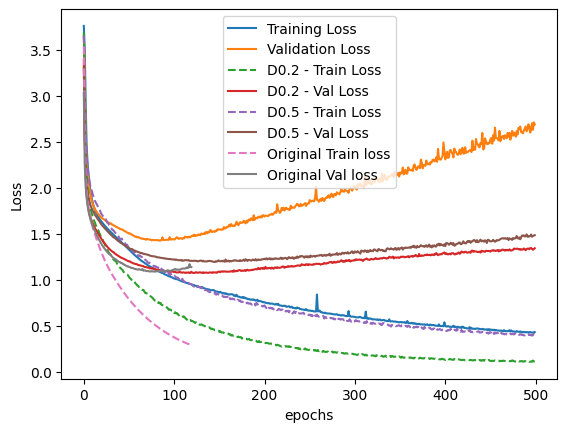

In [37]:
plt.plot(model2_training_history.history['loss'], label="Training Loss")
plt.plot(model2_training_history.history['val_loss'], label="Validation Loss")

plt.plot(model3_training_history.history['loss'], '--', label="D0.2 - Train Loss")
plt.plot(model3_training_history.history['val_loss'], label="D0.2 - Val Loss")

plt.plot(model4_training_history.history['loss'], '--', label="D0.5 - Train Loss")
plt.plot(model4_training_history.history['val_loss'], label="D0.5 - Val Loss")

plt.plot(model_training_history.history['loss'], '--', label="Original Train loss")
plt.plot(model_training_history.history['val_loss'], label="Original Val loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

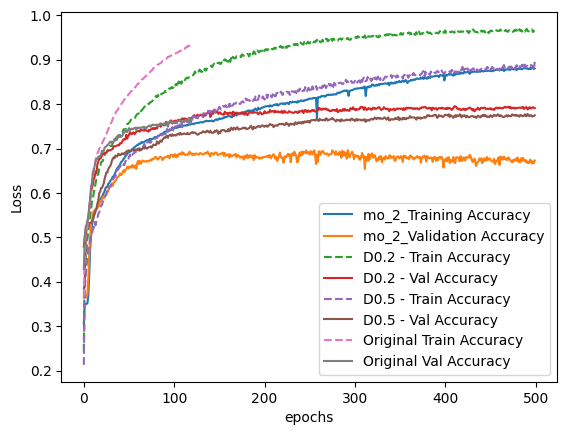

In [39]:
plt.plot(model2_training_history.history['accuracy'], label="mo_2_Training Accuracy")
plt.plot(model2_training_history.history['val_accuracy'], label="mo_2_Validation Accuracy")

plt.plot(model3_training_history.history['accuracy'], '--', label="D0.2 - Train Accuracy")
plt.plot(model3_training_history.history['val_accuracy'], label="D0.2 - Val Accuracy")

plt.plot(model4_training_history.history['accuracy'], '--', label="D0.5 - Train Accuracy")
plt.plot(model4_training_history.history['val_accuracy'], label="D0.5 - Val Accuracy")

plt.plot(model_training_history.history['accuracy'], '--', label="Original Train Accuracy")
plt.plot(model_training_history.history['val_accuracy'], label="Original Val Accuracy")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

- it appears the D0.2 is the best model- however, the slope is too steap- suggesting thatthe learning rate is high and may need to reduced (for both accuracy and loss)

### Batch Normalisation

In our reading we introduced Batch Normalisation as a means to ensure that the variances from earlier layers do not drift too far as we propagate through our network. It also benefits us during training by reducing covariance shift; ensuring that gradient application doesn't then impact other layers too drastically.

For the application of this layer, we must separate out our non-linearities. We insert the BN between the activation function, and the neurons. Dense -> BN -> Activation. As per the original paper; however, recent code created by these authors shows BN applied after activation (ReLU) - this is still wildly debated in practice.

In [22]:
bn_model = keras.Sequential()
bn_model.add(layers.InputLayer(input_shape=(10000,))) # 10000 dimensional input.

bn_model.add(layers.Dense(64))
bn_model.add(layers.BatchNormalization())
bn_model.add(layers.ReLU())

bn_model.add(layers.Dense(64))# 2 Hidden Layers
bn_model.add(layers.BatchNormalization())
bn_model.add(layers.ReLU())

bn_model.add(layers.Dense(46, activation="softmax")) # 46 Output topics possible.
bn_model.summary()

bn_model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.05), # Higher learning rate for demonstration.
    metrics=['accuracy']
)

# Using train, test, val datasets from before.
bn_model_training_history = bn_model.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 150, # train for a bit longer to get a better picture.
    validation_data = (x_val, y_val)
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,726 (2.47 MB)

 Trainable params: 647,470 (2.47 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.4254 - loss: 2.8047 - val_accuracy: 0.5710 - val_loss: 3.4284
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6428 - loss: 1.6999 - val_accuracy: 0.5900 - val_loss: 3.1903
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7151 - loss: 1.3504 - val_accuracy: 0.5800 - val_loss: 3.0058
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7542 - loss: 1.1508 - val_accuracy: 0.5670 - val_loss: 2.8437
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7806 - loss: 1.0107 - val_accuracy: 0.5650 - val_loss: 2.7039
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8026 - loss: 0.8977 - val_accuracy: 0.5480 - val_loss: 2.5764
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8234 - loss: 0.8053 - val_accuracy: 0.5410 - val_loss: 2.4693
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8383 - loss: 0.7270 - val_accuracy: 0.

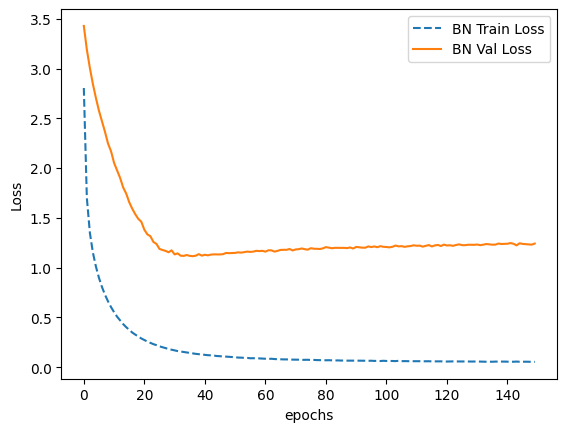

In [23]:
plt.plot(bn_model_training_history.history['loss'], '--', label="BN Train Loss")
plt.plot(bn_model_training_history.history['val_loss'], label="BN Val Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

#### Obsevations
This training graph appears to improve training loss incredibly quickly, at a rate higher than most we've seen so far. However, alongside this, we notice that the validation loss has diverged significantly since around epoch 20, and is slowly going back up.

We would need to investigate the train / val splits to see if it's a data partitioning issue, then look at ways to add additional regularisation, or perhaps tweak model complexity.

### L1 / L2 Regularisation

In our reading we introduced a way to prevent weights from changing too much, or too drastically. Primarily we can look at doing this via L1, L2, or a mix of the two (L1_L2). This can be done for the weights, as well as the biases of a layer (and even to the activation output!).

Let's look at if this can help us with the above.

In [24]:
bn_l2_model = keras.Sequential()
bn_l2_model.add(layers.InputLayer(input_shape=(10000,))) # 10000 dimensional input.

bn_l2_model.add(layers.Dense(64, kernel_regularizer='l2'))
bn_l2_model.add(layers.BatchNormalization())
bn_l2_model.add(layers.ReLU())

bn_l2_model.add(layers.Dense(64, kernel_regularizer='l2'))# 2 Hidden Layers
bn_l2_model.add(layers.BatchNormalization())
bn_l2_model.add(layers.ReLU())

bn_l2_model.add(layers.Dense(46, activation="softmax")) # 46 Output topics possible.
bn_l2_model.summary()

bn_l2_model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.05), # Higher learning rate for demonstration.
    metrics=['accuracy']
)

# Using train, test, val datasets from before.
bn_l2_model_training_history = bn_l2_model.fit(
    x_train_enc_rest,
    y_train_enc_rest,
    batch_size = 512,
    epochs = 150, # train for a bit longer to get a better picture.
    validation_data = (x_val, y_val)
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,726 (2.47 MB)

 Trainable params: 647,470 (2.47 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.4194 - loss: 4.5894 - val_accuracy: 0.5540 - val_loss: 5.3221
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6599 - loss: 3.5493 - val_accuracy: 0.6110 - val_loss: 5.0910
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7132 - loss: 3.1643 - val_accuracy: 0.6150 - val_loss: 4.9488
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7447 - loss: 2.9211 - val_accuracy: 0.6310 - val_loss: 4.8251
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7676 - loss: 2.7352 - val_accuracy: 0.6230 - val_loss: 4.7016
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7879 - loss: 2.5772 - val_accuracy: 0.6280 - val_loss: 4.5788
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8081 - loss: 2.4353 - val_accuracy: 0.5880 - val_loss: 4.4913
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8249 - loss: 2.3118 - val_accuracy: 0.

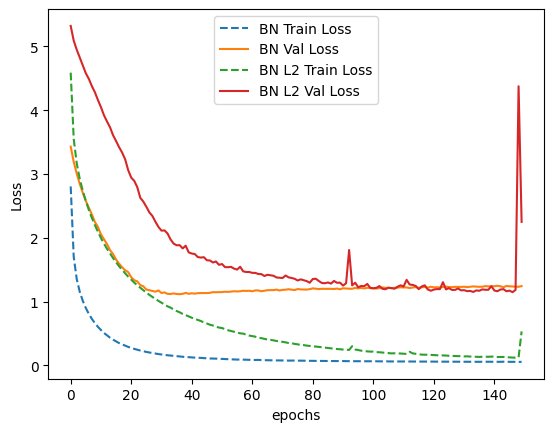

In [25]:
plt.plot(bn_model_training_history.history['loss'], '--', label="BN Train Loss")
plt.plot(bn_model_training_history.history['val_loss'], label="BN Val Loss")

plt.plot(bn_l2_model_training_history.history['loss'], '--', label="BN L2 Train Loss")
plt.plot(bn_l2_model_training_history.history['val_loss'], label="BN L2 Val Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

#### Observations

The L2 regularised approach seems to take longer to get to the plataeu, but generally results in the validation loss following the shape of the training loss. The only difference now is the large gap between them, which could be explained by dataset split differences. Our training accuracy is high, at approx 97%, and the validation loss appears to just about be flattening. We may want to look at training for more epochs to confirm a good stopping point.

### Final Remarks

![Training Curve](https://www.baeldung.com/wp-content/uploads/sites/4/2020/07/fitgraph.jpg)

Source: https://www.baeldung.com/cs/learning-curve-ml

#### Training Loss Curve not decreasing, or Training loss stagnates
This could indicate your model does not have sufficient capacity

#### Train and Validation Loss Diverging

If your validation loss diverges from your training loss, with your validation loss flatlining or even going up again then your model is overfit. Potential solutions:
* Add regularisation (Dropout / BN / L1 / L2 / etc)
* Reduce Model Capacity (if model is overly complex)
* Verify your Train and Validation splits are staistically comparable (Try change the shuffle seed.). Divergence could be caused by the sets being different.